In [334]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from tqdm.autonotebook import tqdm

import bandit.environment as env
from bandit.policy import EGreedy, Softmax
from bandit.tensorflow import (
    NeuralBandit,
    NeuralPerArmBandit,
    NeuralPolicyBandit,
    create_models,
)

sns.set_theme()

In [335]:
import importlib

import bandit

importlib.reload(bandit)
importlib.reload(bandit.tensorflow)

<module 'bandit.tensorflow' from '/Users/alextanhongpin/Documents/python/python-bandit/bandit/tensorflow.py'>

In [333]:
import keras

keras.__version__

'2.15.0'

In [111]:
N = 1000


def run_simulation(bandit, policy, n=N, dynamic=False):
    total_reward = 0
    avg_rewards = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n), disable=False):
        state = env.observe(rng)

        # 1. Predict the action.
        rewards = bandit.pull(state)

        action = policy(rewards)

        # 2. Act and get the reward.
        if dynamic and i > n // 2:
            get_cost = env.get_cost_new
        else:
            get_cost = env.get_cost
        reward = get_cost(state, env.actions[action])
        # Change reward to 0 or 1 instead of -1 or 1

        # 3. Update the model.
        bandit.update(state, action, reward)

        # 4. Save the reward.
        total_reward += max(0, reward)
        avg_rewards.append(total_reward / (i + 1))
    return avg_rewards, total_reward


expected = [
    ({"user": "Tom", "time_of_day": "morning"}, "politics"),
    ({"user": "Tom", "time_of_day": "afternoon"}, "music"),
    ({"user": "Anna", "time_of_day": "morning"}, "sports"),
    ({"user": "Anna", "time_of_day": "afternoon"}, "politics"),
]


def debug_bandit(bandit):
    for i, act in enumerate(env.actions):
        print(i, act)
    print()
    policy = EGreedy(epsilon=0.0)

    for state, want in expected:
        rewards = bandit.pull(state)
        got = env.actions[policy(rewards)]
        if got != want:
            encoded = bandit.preprocess.transform(
                [env.feature_interaction(state, env.actions.index(want))]
            ).toarray()
            print(
                f"state({state}): got {got} ({env.actions.index(got)}), want {want} ({env.actions.index(want)})"
            )
            print(f"encoded {encoded}")
            print(f"rewards {np.round(rewards, 2)}, {np.argmax(rewards)}")
            print()

## Neural Bandit - Static

In [5]:
policy = EGreedy(epsilon=0.0)
bandit = NeuralBandit(n_arms=len(env.actions), batch=1)

avg_rewards, total_reward = run_simulation(bandit, policy, n=N, dynamic=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.06it/s]


In [6]:
total_reward

691.0

In [7]:
debug_bandit(bandit)

0 politics
1 sports
2 music
3 food
4 finance
5 health
6 camping

state({'user': 'Tom', 'time_of_day': 'afternoon'}): got finance (4), want music (2)
encoded [[-1.  0.  1.  0.  1.  0. -1. -1.]]
rewards [0. 0. 0. 0. 0. 0. 0.], 4



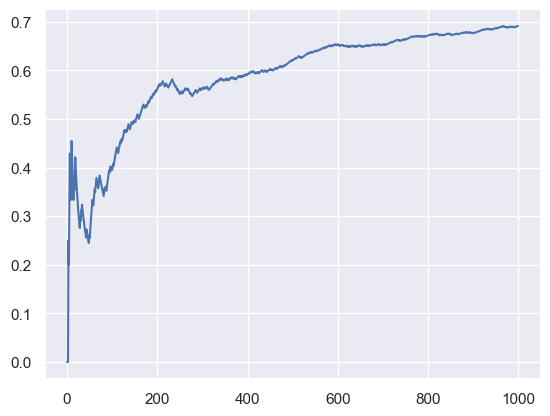

In [8]:
plt.plot(range(N), avg_rewards)

## Neural Bandit - Dynamic

In [9]:
policy = EGreedy(epsilon=0.0)
bandit = NeuralBandit(n_arms=len(env.actions), batch=1)

avg_rewards, total_reward = run_simulation(bandit, policy, n=N, dynamic=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.04it/s]


In [10]:
total_reward

722.0

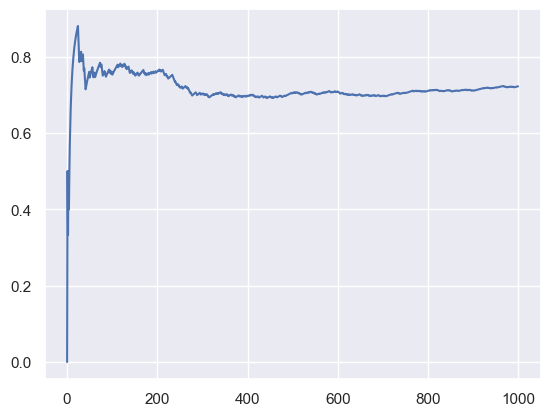

In [11]:
plt.plot(range(N), avg_rewards)

In [12]:
debug_bandit(bandit)

0 politics
1 sports
2 music
3 food
4 finance
5 health
6 camping

state({'user': 'Tom', 'time_of_day': 'afternoon'}): got camping (6), want music (2)
encoded [[-1.  0.  1.  0.  1.  0. -1. -1.]]
rewards [0. 0. 0. 0. 0. 0. 0.], 4

state({'user': 'Anna', 'time_of_day': 'afternoon'}): got sports (1), want politics (0)
encoded [[-1.  0. -1.  0.  0.  0. -1.  0.]]
rewards [0. 0. 0. 0. 0. 0. 0.], 1



Why is the tensorflow version performing worse than the scikit-learn MultiLayerPerceptron? The example has been modified to ue the `one_hot_encoding` instead of `feature_interaction`, but the result is still the same.

How about the pytorch version?

## Per-arm Bandit

In [13]:
policy = EGreedy(epsilon=0.0)
bandit = NeuralPerArmBandit(batch=1, models=create_models(len(env.actions)))

avg_rewards, total_reward = run_simulation(bandit, policy, n=N, dynamic=False)

  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:29<00:00, 11.23it/s]


In [14]:
total_reward

622.0

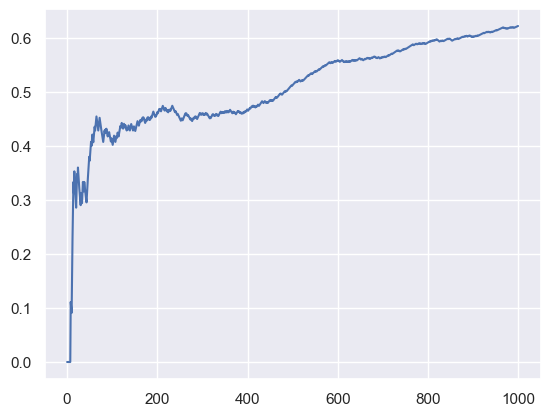

In [15]:
plt.plot(range(N), avg_rewards)

In [16]:
debug_bandit(bandit)

0 politics
1 sports
2 music
3 food
4 finance
5 health
6 camping

state({'user': 'Tom', 'time_of_day': 'afternoon'}): got politics (0), want music (2)
encoded [[-1.  0.  1.  0.  1.  0. -1. -1.]]
rewards [0.98 0.09 0.06 0.27 0.15 0.35 0.53], 0



## Softmax Policy - static

In [336]:
N = 500
policy = EGreedy(epsilon=0.0)
bandit = NeuralPolicyBandit(n_arms=len(env.actions))

avg_rewards, total_reward = run_simulation(bandit, policy, n=N, dynamic=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.05it/s]


In [337]:
total_reward

387.0

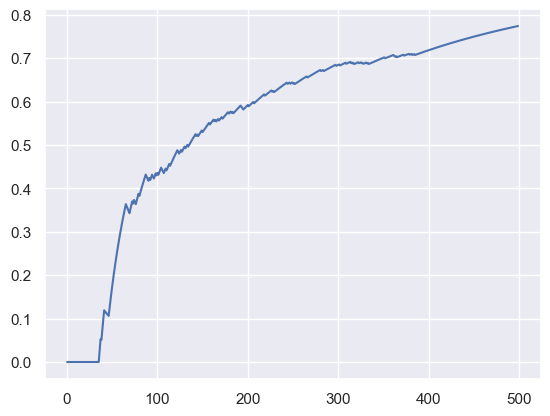

In [338]:
plt.plot(range(N), avg_rewards)

In [339]:
debug_bandit(bandit)

0 politics
1 sports
2 music
3 food
4 finance
5 health
6 camping



## Softmax Policy - dynamic

In [340]:
N = 500
policy = EGreedy(epsilon=0.0)
bandit = NeuralPolicyBandit(n_arms=len(env.actions))

avg_rewards, total_reward = run_simulation(bandit, policy, n=N, dynamic=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.18it/s]


In [341]:
total_reward

330.0

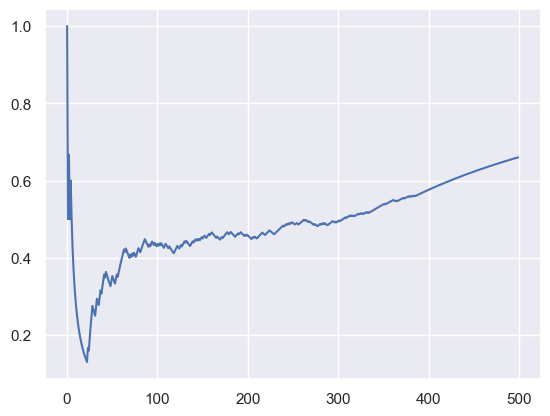

In [342]:
plt.plot(range(N), avg_rewards)

In [343]:
debug_bandit(bandit)

0 politics
1 sports
2 music
3 food
4 finance
5 health
6 camping

state({'user': 'Tom', 'time_of_day': 'afternoon'}): got sports (1), want music (2)
encoded [[-1.  0.  1.  0.  1.  0. -1. -1.]]
rewards [0.02 0.97 0.   0.   0.   0.   0.  ], 1

state({'user': 'Anna', 'time_of_day': 'afternoon'}): got sports (1), want politics (0)
encoded [[-1.  0. -1.  0.  0.  0. -1.  0.]]
rewards [0. 1. 0. 0. 0. 0. 0.], 1

